<a href="https://colab.research.google.com/github/robbymister/ShoeIdentifier/blob/main/p3_annotated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC321H5 Project 3.

**Deadline**: Thursday, March. 19, by 9pm

**Submission**: Submit a PDF export of the completed notebook. 

**Late Submission**: Please see the syllabus for the late submission criteria.

In this assignment, we will build a convolutional neural network that can predict 
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you starter
code to help make data processing a bit easier, you'll have a chance to build your
neural network all by yourself!

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that your
TA can understand what you are doing and why.

If you find exporting the Google Colab notebook to be difficult, you can create
your own PDF report that includes your code, written solutions, and outputs that
the graders need to assess your work.

In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import sklearn

import torch
import torch.nn as nn
import torch.optim as optim

## Question 1. Data

Download the data from the course website at https://www.cs.toronto.edu/~lczhang/321/files/p3data.zip

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets.

We've separated `test_w` and `test_m` so that we can track our model performance 
for women's shoes and men's shoes separately. Each of the test sets contain images
from 10 students who submitted images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


After you have done so, read this entire section (ideally this entire handout)
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.

### Part (a) -- 1 pts

Why might we care about the accuracies of the men's and women's shoes as two
separate measures? Why would we expect our model accuracies for the two groups
to be different?

Recall that your application may help people who are visually impaired.

In [ ]:
# Your answer goes here. Please make sure it is not cut off
'''
Men's shoes and women's shoes have different shapes, sizes and styles. In the case
where the shoes between men and women are similar then the model should be able to
predict which shoe will complete the man/woman's pair of shoes.
'''

### Part (b) -- 4 pts

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of students allocated to train, valid, or test
- `3` - the 3 pairs of shoes submitted by that student
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image submitted
by the 5th student.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair. 
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair, submitted by
the same student.

When you first load the images using (for example) `plt.imread`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is the alpha channel for transparent
pixels, and should be removed. 
The pixel intensities are stored as an integer between 0 and 255.
Divide the intensities by 255 so that you have floating-point values between 0 and 1. Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

This function might take a while to run---it takes 3-4 minutes for me to just
load the files from Google Drive.  If you want to avoid
running this code multiple times, you can save 
your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [ ]:
# Your code goes here. Make sure it does not get cut off
# You can use the code below to help you get started. You're welcome to modify
# the code or remove it entirely: it's just here so that you don't get stuck
# reading files

import glob

path = "/content/gdrive/My Drive/CSC321/p3data/train/*.jpg" # edit me
imagesTrain = {}

for file in glob.glob(path):
  img = plt.imread(file)           # read the image as a numpy array
  formattedImg = img[:, :, :3]/255 - 0.5 # remove the alpha channel

  filename = file.split("/")[-1]   # get the name of the .jpg file
  personName, shoeNum, leftRight, genderJpg = filename.strip().split('_')
  
  if personName not in imagesTrain:
    imagesTrain[personName] = {
        'left': [],
        'right': []
    }
  imagesTrain[personName][leftRight].append(formattedImg)

  # object-oriented approach

path = "/content/gdrive/My Drive/CSC321/p3data/test_w/*.jpg" # edit me
imagesTestW = {}
for file in glob.glob(path):
  img = plt.imread(file)           # read the image as a numpy array
  formattedImg = img[:, :, :3]/255 - 0.5 # remove the alpha channel

  filename = file.split("/")[-1]   # get the name of the .jpg file
  personName, shoeNum, leftRight, genderJpg = filename.strip().split('_')

  if personName not in imagesTestW:
    imagesTestW[personName] = {
        'left': [],
        'right': []
    }
  imagesTestW[personName][leftRight].append(formattedImg)

path = "/content/gdrive/My Drive/CSC321/p3data/test_m/*.jpg" # edit me
imagesTestM = {}
for file in glob.glob(path):
  img = plt.imread(file)           # read the image as a numpy array
  formattedImg = img[:, :, :3]/255 - 0.5 # remove the alpha channel
  filename = file.split("/")[-1]   # get the name of the .jpg file
  personName, shoeNum, leftRight, genderJpg = filename.strip().split('_')

  if personName not in imagesTestM:
    imagesTestM[personName] = {
        'left': [],
        'right': []
    }
  imagesTestM[personName][leftRight].append(formattedImg)


In [ ]:
imagesTrainKeys = list(imagesTrain.keys())
validRatio = 0.2
validSize = int(len(imagesTrainKeys)*validRatio)
trainKeys, validKeys = imagesTrainKeys[:-validSize], imagesTrainKeys[-validSize:] 

# test data
train_data = []

for trainKey in trainKeys:
  images = []
  for key in ['left', 'right']:
    images.append(imagesTrain[trainKey][key])
  train_data.append(images)

train_data = np.array(train_data)

# validation data
valid_data = []

for validKey in validKeys:
  images = []
  for key in ['left', 'right']:
    images.append(imagesTrain[validKey][key])
  valid_data.append(images)

valid_data = np.array(valid_data)

# test w data
test_w = []

for leftRight in imagesTestW.values():
  images = []
  for key in ['left', 'right']:
    images.append(leftRight[key])
  test_w.append(images)

test_w = np.array(test_w)

# test m data
test_m = []
for leftRight in imagesTestM.values():
  images = []
  for key in ['left', 'right']:
    images.append(leftRight[key])
  test_m.append(images)

test_m = np.array(test_m)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


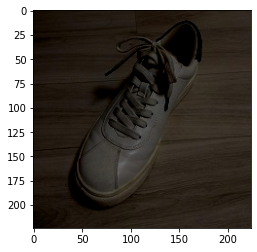

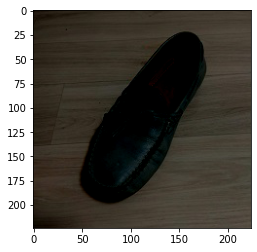

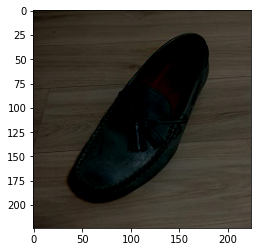

In [ ]:
# Run this code, include the image in your PDF submission
plt.figure()
plt.imshow(train_data[4,0,0,:,:,:]) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]) # right shoe of second pair submitted by 5th student

### Part (c) -- 2 pts

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where 
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in part (c).

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

(Later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires)

(90, 2, 3, 224, 224, 3)
(270, 448, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


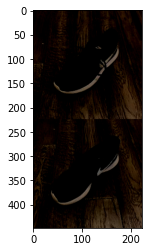

In [ ]:
# Your code goes here
def generate_same_pair(data):
  same_pairs = []

  for shoe in data:
    same_shoes = []

    for i in range(3):
      same_pair = np.vstack((shoe[0][i], shoe[1][i]))
      same_shoes.append(same_pair)

    same_pairs.extend(same_shoes)

  return np.array(same_pairs)


# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(train_data)[0]) # should show 2 shoes from the same pair

### Part (d) -- 2 pts

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by 
each student.

Theoretically, for each student image submissions, there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(90, 2, 3, 224, 224, 3)
(270, 448, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


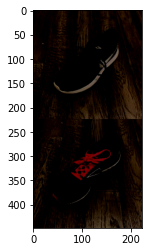

In [ ]:
def generate_different_pair(allShoes: '[[[..., leftshoe3][...,rightshoe3]],...]'):
  all_different_pairs = []

  for shoes in allShoes:
    different_pairs = []

    for i in range(3):
      j = (i+1)%3
      different_pair = np.vstack((shoes[0][i],shoes[1][j]))
      different_pairs.append(different_pair)

    all_different_pairs.extend(different_pairs)
  
  return np.array(all_different_pairs)

# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(train_data)[0]) # should show 2 shoes from different pairs

### Part (e) -- 1 pts

Why do we insist that the different pairs of shoes still come from the same
student?  (Hint: what else do images from the same student have in common?)

In [ ]:
# Your answer goes here. Please make sure it is not cut off
'''
The backgrounds and lighting is similar in photos produced by the same student.
If we train by comparing shoes to other students' shoes in the training set, 
our model may find good accuracy in modelling the differences in surroundings,
instead of identifying the signal in the shoes themselves (irrespective of the 
background and lighting), which is the ultimate objective of our model.
'''

### Part (f) -- 1 pts

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and 
1% of the images are shoes that *are* from the same pair. Why could this be a problem?

In [ ]:
# Your answer goes here. Please make sure it is not cut off
'''
We can obtain a very high recall by simply classifying every image as different.
That is, we can get a 99% accuracy with a model that returns false for every
input. However, this would be overfitting to our priors, and not modelling
true features of a shoe that makes them distinct.
'''

## Question 2. Convolutional Neural Networks

Before starting this question, we recommend reviewing the lecture and tutorial materials
on convolutional neural networks.

In this section, we will build two CNN models in PyTorch.

### Part (a) -- 4 pts

Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $n \times 2$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $n \times 2$ channels, and outputs $n \times 4$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $n \times 4$ channels, and outputs $n \times 8$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

Make the variable $n$ a parameter of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the tutorial materials and your
past projects to figure out where they are.

In [ ]:
# This constructor follows the exact instructions states above
class CNN(nn.Module):
    def __init__(self, n=4):
        super(CNN, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=n,
                               kernel_size=3,
                               padding=1)
        self.conv2 = nn.Conv2d(in_channels=n,
                               out_channels=n*2,
                               kernel_size=3,
                               padding=1)  
        self.conv3 = nn.Conv2d(in_channels=n*2,
                               out_channels=n*4,
                               kernel_size=3,
                               padding=1) 
        self.conv4 = nn.Conv2d(in_channels=n*4,
                               out_channels=n*8,
                               kernel_size=3,
                               padding=1)
        self.fc1Size = int((n*8)*(448/(pow(2,4)))*(224/(pow(2,4)))) # n*8 outputs, 448*224 image pooled 4 times

        self.fc1 = nn.Linear(self.fc1Size, 100)
        self.fc2 = nn.Linear(100, 2)


    def forward(self, x):

        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))

        x = x.view(-1, self.fc1Size) # flatten
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

### Part (b) -- 4 pts

Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://www.cs.toronto.edu/~lczhang/321/hw/p3model.png" width="400px" />

Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

In [ ]:
class CNNChannel(nn.Module):
    def __init__(self, n=4):
        super(CNNChannel, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(in_channels=6,
                               out_channels=n,
                               kernel_size=3,
                               padding=1)
        self.conv2 = nn.Conv2d(in_channels=n,
                               out_channels=n*2,
                               kernel_size=3,
                               padding=1)  
        self.conv3 = nn.Conv2d(in_channels=n*2,
                               out_channels=n*4,
                               kernel_size=3,
                               padding=1) 
        self.conv4 = nn.Conv2d(in_channels=n*4,
                               out_channels=n*8,
                               kernel_size=3,
                               padding=1)
        self.fc1Size = int((n*8)*(224/(pow(2,4)))*(224/(pow(2,4)))) # n*8 outputs, 224*224 image pooled 4 times
        self.fc1 = nn.Linear(self.fc1Size, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = np.swapaxes(x,0,1) # 3 x n x 224 x 448

        x1, x2 = x[:,:,:,:224], x[:,:,:,224:] # 3 x n x 224 x 224

        x = np.vstack((x1, x2)) # 6 x n x 224 x 224

        x = np.swapaxes(x,0,1) # n x 6 x 224 x 224
    
        x = torch.Tensor(x)

        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(-1, self.fc1Size) # flatten
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

## Part (c) -- 2 pts

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target (just like in Project 2). We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss`. In fact, this is a standard practice in machine learning because
this architecture performs better!

Explain why this architecture might give you better performance.

In [ ]:
# Your answer goes here. Please make sure it is not cut off
'''
No sigmoid beforehand. This speeds up the process, as we use less computing power.
'''

## Part (d) -- 2 pts

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning. Explain why one of these models performs better.

In [ ]:
# Your answer goes here. Please make sure it is not cut off
'''
CNNChannel should perform better, because by putting the difference in the 
input channel, the kernal that we train now explicitly sees the difference for 
every convolution position, rather than with the regular CNN who only sees the 
difference half of the convolution positions. 
'''

## Part (e) -- 2 pts

The function `get_accuracy` is written for you. You may need to modify this
function depending on how you set up your model and training.

Unlike in project 2, we will separately compute the model accuracy on the
positive and negative samples.  Explain why we may wish to track these
two values separately.

In [ ]:
# Your answer goes here. Please make sure it is not cut off

In [ ]:
def get_accuracy(model, data, batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).transpose(1, 3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        pos_correct += (pred == 1).sum()
    
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).transpose(1, 3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

## Question 3. Training

Now, we will write the functions required to train the model.

### Part (a) -- 10 pts

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.
This function should be somewhat similar to the training code that you wrote
in Project 2, but with a major difference in the way we treat our training data.

Since our positive and negative training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data! In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here's what we will be looking for:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and 
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions "NCHW",
  use the `.transpose()` method in either PyTorch or numpy
- computing the forward and backward passes
- after every epoch, checkpoint your model (Project 2 has in-depth instructions and examples for how to do this)
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

In [ ]:
def train_model(model, data, batch_size=1, num_epochs=1, 
                learning_rate=0.01, momentum=0.99, weight_decay=0,
                optimizer='sgd'):
  
    criterion = nn.CrossEntropyLoss()

    assert optimizer in ("sgd", "adam")
    if optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(),
                              lr=learning_rate,
                              momentum=momentum,
                              weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(),
                               lr=learning_rate,
                               weight_decay=weight_decay)

    iters, losses, train_acc, val_acc = [], [], [], []

    n=0
    for epoch in range(num_epochs):
        for batch_i in range(0, data.shape[0], int(batch_size/2)):

            batch_xs = data[batch_i:batch_i+int(batch_size/2)]

            data_pos = generate_same_pair(batch_xs) # n*3 x 448 x 224 x 3
            data_neg = generate_different_pair(batch_xs)

            data_pos = np.swapaxes(data_pos, 1,3) # n*3 x 3 x 224 x 448
            data_neg = np.swapaxes(data_neg, 1,3)
            
            data_tgt = np.vstack((data_pos, data_neg))
            imgs = torch.Tensor(data_tgt) 

            pos_labels = np.ones(int(batch_size/2)*3)
            neg_labels = np.zeros(int(batch_size/2)*3)

            labels = np.hstack((pos_labels, neg_labels))
            labels = torch.Tensor(labels).long()

            out = model(imgs)

            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(np.average(get_accuracy(model, data))) # compute training accuracy 
        val_acc.append(np.average(get_accuracy(model, valid_data)))  # compute validation accuracy
        n += 1

        
    # plotting
    plt.title("Learning Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


### Part (b) -- 2 pts

Sanity check your code from Q3(a) and from Q2(a) and Q2(b) by showing that your models
can memorize a very small subset of the training set (e.g. 5 images).
You should be able to achieve 90%+ accuracy
relatively quickly (within ~30 or so iterations).

(If you have trouble with CNN() but not CNNChannel(), try reducing $n$, e.g. try working
with the model `CNN(2)`)

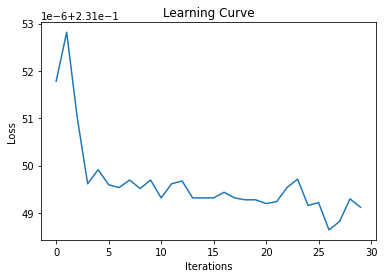

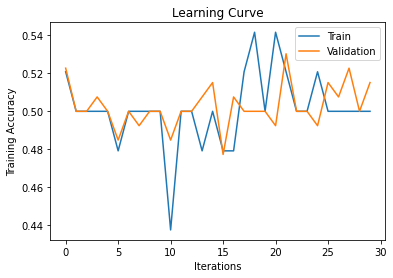

Final Training Accuracy: 0.5
Final Validation Accuracy: 0.5151515151515151
cnn accuracy: (0.20833333333333334, 0.7916666666666666)


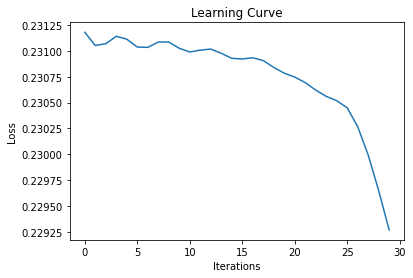

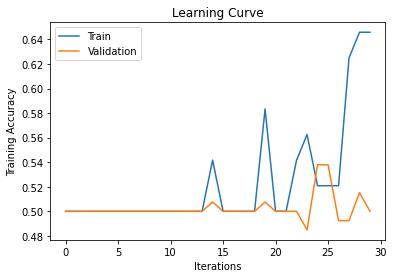

Final Training Accuracy: 0.6458333333333333
Final Validation Accuracy: 0.5
cnn channel accuracy: (0.5416666666666666, 0.75)


In [ ]:
# Write your code here. Remember to include your results so that your TA can
# see that your model attains a high training accuracy. (UPDATED March 12)
cnn = CNN()
cnnChannel = CNNChannel()

n = 8
data = train_data[:n]

train_model(cnn, data, 3, 30)
print(f'cnn accuracy: {get_accuracy(cnn, data, 1)}')

train_model(cnnChannel, data, 3, 30)
print(f'cnn channel accuracy: {get_accuracy(cnnChannel, data, 1)}')

### Part (c) -- 4 pts

Train your models from Q2(a) and Q2(b). You will want to explore the effects of a few 
hyperparameters, including the learning rate, batch size, choice of $n$, and potentially
the kernel size. You do not need to check all values for all hyperparameters. Instead,
get an intuition about what each of the parameters do.

In this section, explain how you tuned your hyperparameters.

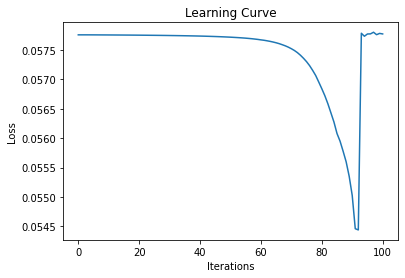

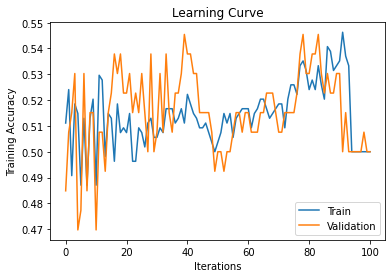

Final Training Accuracy: 0.5
Final Validation Accuracy: 0.5
cnn accuracy: (1.0, 0.0)


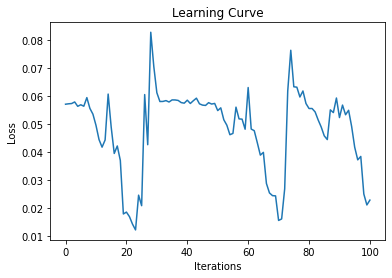

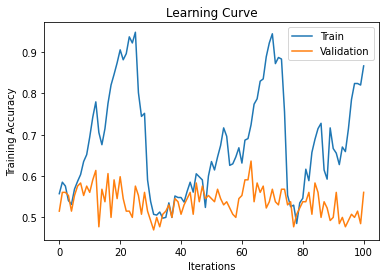

Final Training Accuracy: 0.8666666666666667
Final Validation Accuracy: 0.5606060606060607
cnn channel accuracy: (0.9444444444444444, 0.7888888888888889)


'\nEpoch: number of times the full data set is ran through. After running many epochs\n(around 100) there was not much of an effect, and 30 was found to be sufficient\nnumber of passes through the dataset.\n\nBatch Size: defines the number of samples to work through before updating the \ninternal model parameters. 11 was chosen as it seemed to show a nice split between\nnot overfitting the data and adjusting enough over a single run.\n\nLearning Rate: the default learning rate was used and not changed as the weight\nadjustments were sufficient.\n\nKernel Size: Not adjusted from default, not much difference noticed with tuning.\n'

In [ ]:
# Include the training curves for the two models.
data = train_data
train_model(cnn, data, 12, 101)
print(f'cnn accuracy: {get_accuracy(cnn, data, 1)}')

train_model(cnnChannel, data, 12, 101)
print(f'cnn channel accuracy: {get_accuracy(cnnChannel, data, 1)}')

'''
Epoch: number of times the full data set is ran through. After running many epochs
(around 100) there was not much of an effect, and 30 was found to be sufficient
number of passes through the dataset.

Batch Size: defines the number of samples to work through before updating the 
internal model parameters. 11 was chosen as it seemed to show a nice split between
not overfitting the data and adjusting enough over a single run.

Learning Rate: the default learning rate was used and not changed as the weight
adjustments were sufficient.

Kernel Size: Not adjusted from default, not much difference noticed with tuning.
'''


### Part (d) -- 2 pts

Include your training curves for the **best** models from each of Q2(a) and Q2(b).
These are the models that you will use in Question 4.

In [ ]:
# Include the training curves for the two models.
'''
The two curves above above in Q3(c) are the curves for the two best models.
'''

## Question 4.

### Part (a) -- 3 pts

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the checkpoint of the model
architecture that produces the best validation accuracy. That is,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

In [ ]:
# Write your code here. Make sure to include the test accuracy in your report
def get_last_weight(model, data, batch_size=1, num_epochs=1, 
                learning_rate=0.01, momentum=0.99, weight_decay=0,
                optimizer='sgd'):
  
    criterion = nn.CrossEntropyLoss()

    assert optimizer in ("sgd", "adam")
    if optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(),
                              lr=learning_rate,
                              momentum=momentum,
                              weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(),
                               lr=learning_rate,
                               weight_decay=weight_decay)

    iters, losses, train_acc, val_acc = [], [], [], []

    n=0
    for epoch in range(num_epochs):
        for batch_i in range(0, data.shape[0], int(batch_size/2)):

            batch_xs = data[batch_i:batch_i+int(batch_size/2)]

            data_pos = generate_same_pair(batch_xs) # n*3 x 448 x 224 x 3
            data_neg = generate_different_pair(batch_xs)

            data_pos = np.swapaxes(data_pos, 1,3) # n*3 x 3 x 224 x 448
            data_neg = np.swapaxes(data_neg, 1,3)
            
            data_tgt = np.vstack((data_pos, data_neg))
            imgs = torch.Tensor(data_tgt) 

            pos_labels = np.ones(int(batch_size/2)*3)
            neg_labels = np.zeros(int(batch_size/2)*3)

            labels = np.hstack((pos_labels, neg_labels))
            labels = torch.Tensor(labels).long()

            out = model(imgs)

            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(np.average(get_accuracy(model, data))) # compute training accuracy 
        val_acc.append(np.average(get_accuracy(model, valid_data)))  # compute validation accuracy
        n += 1

    return model.fc2.weight

data = train_data
weights = get_last_weight(cnnChannel, data, 12, 27) # 27th epoch gave highest weights
print(weights)


Parameter containing:
tensor([[-0.3773,  0.1582, -0.1232,  0.0132, -0.3297, -0.7379, -0.0904, -0.0334,
         -0.0116, -0.2455, -0.4074, -0.4649, -0.2039,  0.7033, -0.5907, -0.0326,
         -0.0756, -0.3797, -0.2215,  0.2465, -0.4225, -0.3946, -0.1976, -0.2868,
         -0.4173,  0.6170,  0.3281,  0.4859,  0.2199,  0.0863, -1.3003,  0.3990,
         -0.4685,  0.0433,  0.1329, -0.2363,  0.3507,  0.0210, -0.1577, -0.0317,
          0.2597,  0.9744,  0.0019, -0.3105, -0.3204, -0.7058,  0.1796, -0.6188,
         -0.2549, -0.9166,  0.4804, -0.2558, -0.0141,  0.6064,  0.9014, -0.2608,
          0.3324, -0.6446,  0.1349, -0.5364, -0.6391, -0.0430, -0.1055, -0.0669,
          0.1947, -0.0275,  0.9953,  0.1308, -0.1813, -0.2476, -0.2009, -0.2082,
         -0.2175,  0.0445, -0.0640,  0.4127, -0.7151,  0.1542,  0.5484, -0.0938,
          0.0081,  0.0552,  0.2199, -0.1185, -0.1810, -0.4433, -1.1532, -0.0963,
         -0.6502,  0.6300,  0.0661,  0.0794,  0.1176,  0.2164, -0.0964,  0.3091,
      

### Part (b) -- 2 pts

Display one set of men's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the men's shoes test set,
display one set of inputs that your model classified incorrectly.

# Correctly classified:
![shoe1](https://drive.google.com/uc?id=1REuIhFzekCd3W5sLTJ4bMEpdvIl8YN6j) ![shoe1](https://drive.google.com/uc?id=1zdlBNfGPxuRONQVTehfDIunqd5zFqPmo) 

# Incorrectly classified:
![alt text](https://drive.google.com/uc?id=1dQIDEqlrJo8Qsxg-N92_51QqJLO3TJpD)
![alt text](https://drive.google.com/uc?id=1egBgeg1cdP_4JWCQ_UPtjGLwSi8aI-Ky)



### Part (c) -- 2 pts

Display one set of women's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the women's shoes test set,
display one set of inputs that your model classified incorrectly.



# Correctly classified:
![shoe1](https://drive.google.com/uc?id=1ddsLILaNtD6NfW7pt9LquYm80r6ZBA4s) ![shoe1](https://drive.google.com/uc?id=1JOb769qoyrcABfz9ol5onOLYlvLuk6_q) 

# Incorrectly classified:
![shoe1](https://drive.google.com/uc?id=1FJ4t9pSmKVFkdyOZysIRd2PugEvF5Mw3) ![shoe2](https://drive.google.com/uc?id=1J4GPehsv2b5xktkc98et1Ql3dJRKMv4r) 